# Chat Intents

## UMAP + HDBSCAN

**Summary**

This notebook outlines a way to automatically determine the best hyperparameters for UMAP + HDBSCAN. See the chatintents_tutorial.ipynb notebook for a tutorial of the chatintents package, which packages and simplifies the functionality outlined below.


In [1]:
import random
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hdbscan
import umap
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm.notebook import trange
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

## Load data and pre-trained models

In [2]:
data_sample = pd.read_csv('../data/processed/data_sample.csv')
data_sample.head()

,Unnamed: 0,text,category,cleaned_text
0,1024,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,im worried card might lost mail long usually take arrive
1,9405,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,got charged fee shouldnt cash
2,9368,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,charge making withdrawal took money account earlier charged
3,3414,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,issue account dont see cheque deposit made yesterday please assist
4,7402,Are there ways for other people to send me money?,receiving_money,way people send money


In [3]:
all_intents = list(data_sample['text'])
len(all_intents)

1000

In [4]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)

print(f"module {module_url} loaded")

INFO:absl:Using /var/folders/_d/glx67tx142z43y0r2thyl3g80000gn/T/tfhub_modules to cache modules.


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [5]:
model_st1 = SentenceTransformer('all-mpnet-base-v2')
model_st2 = SentenceTransformer('all-MiniLM-L6-v2')
model_st3 = SentenceTransformer('all-distilroberta-v1')

In [6]:
def embed(model, model_type, sentences):
    if model_type == 'use':
        embeddings = model(sentences)
    elif model_type == 'sentence transformer':
        embeddings = model.encode(sentences, show_progress_bar=True)
    
    return embeddings

In [7]:
embeddings_use = embed(model_use, 'use', all_intents)

In [8]:
embeddings_st1 = embed(model_st1, 'sentence transformer', all_intents)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [9]:
embeddings_st2 = embed(model_st2, 'sentence transformer', all_intents)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [10]:
embeddings_st3 = embed(model_st3, 'sentence transformer', all_intents)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [11]:
embeddings = [embeddings_use, embeddings_st1, embeddings_st2, embeddings_st3]

for embedding in embeddings:
    print(embedding.shape)

(1000, 512)
(1000, 768)
(1000, 384)
(1000, 768)


## Helper functions

In [12]:
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      min_samples = None,
                      random_state = None):
    """
    Returns HDBSCAN objects after first performing dimensionality reduction using UMAP
    
    Arguments:
        message_embeddings: embeddings to use
        n_neighbors: int, UMAP hyperparameter n_neighbors
        n_components: int, UMAP hyperparameter n_components
        min_cluster_size: int, HDBSCAN hyperparameter min_cluster_size
        min_samples: int, HDBSCAN hyperparameter min_samples
        random_state: int, random seed
        
    Returns:
        clusters: HDBSCAN object of clusters
    """
    
    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors, 
                                n_components = n_components, 
                                metric = 'cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, 
                               min_samples = min_samples,
                               metric='euclidean', 
                               gen_min_span_tree=True,
                               cluster_selection_method='eom').fit(umap_embeddings)
    
    return clusters

In [13]:
def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given clustering

    Arguments:
        clusters: HDBSCAN clustering object
        prob_threshold: float, probability threshold to use for deciding
                        what cluster labels are considered low confidence

    Returns:
        label_count: int, number of unique cluster labels, including noise
        cost: float, fraction of data points whose cluster assignment has
              a probability below cutoff threshold
    """
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

In [35]:
def random_search(embeddings, space, num_evals):
    """
    Randomly search parameter space of clustering pipeline

    Arguments:
        embeddings: embeddings to use
        space: dict, contains keys for 'n_neighbors', 'n_components',
               and 'min_cluster_size' and values with
               corresponding lists or ranges of parameters to search
        num_evals: int, number of random parameter combinations to try

    Returns:
        df_result: pandas dataframe containing info on each evaluation
                   performed, including run_id, parameters used, label
                   count, and cost
    """
    
    results = []
    
    for i in trange(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        n_components = random.choice(space['n_components'])
        min_cluster_size = random.choice(space['min_cluster_size'])
        random_state = space['random_state']
        
        clusters = generate_clusters(embeddings, 
                                     n_neighbors=n_neighbors, 
                                     n_components=n_components, 
                                     min_cluster_size=min_cluster_size, 
                                     random_state=random_state)
    
        label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
                
        results.append([i, n_neighbors, n_components, min_cluster_size, label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'n_neighbors', 'n_components', 
                                               'min_cluster_size', 'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

In [36]:
def objective(params, embeddings, label_lower, label_upper):
    """
    Objective function for hyperopt to minimize

    Arguments:
        params: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', 'random_state' and
               their values to use for evaluation
        embeddings: embeddings to use
        label_lower: int, lower end of range of number of expected clusters
        label_upper: int, upper end of range of number of expected clusters

    Returns:
        loss: cost function result incorporating penalties for falling
              outside desired range for number of clusters
        label_count: int, number of unique cluster labels, including noise
        status: string, hypoeropt status

        """
    
    clusters = generate_clusters(embeddings, 
                                 n_neighbors = params['n_neighbors'], 
                                 n_components = params['n_components'], 
                                 min_cluster_size = params['min_cluster_size'],
                                 random_state = params['random_state'])
    
    label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
    
    #15% penalty on the cost function if outside the desired range of groups
    if (label_count < label_lower) | (label_count > label_upper):
        penalty = 0.15 
    else:
        penalty = 0
    
    loss = cost + penalty
    
    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

In [37]:
def bayesian_search(embeddings, space, label_lower, label_upper, max_evals=100):
    """
    Perform bayesian search on hyperparameter space using hyperopt

    Arguments:
        embeddings: embeddings to use
        space: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', and 'random_state' and
               values that use built-in hyperopt functions to define
               search spaces for each
        label_lower: int, lower end of range of number of expected clusters
        label_upper: int, upper end of range of number of expected clusters
        max_evals: int, maximum number of parameter combinations to try

    Saves the following to instance variables:
        best_params: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', 'min_samples', and 'random_state' and
               values associated with lowest cost scenario tested
        best_clusters: HDBSCAN object associated with lowest cost scenario
                       tested
        trials: hyperopt trials object for search

        """
    
    trials = Trials()
    fmin_objective = partial(objective, 
                             embeddings=embeddings, 
                             label_lower=label_lower,
                             label_upper=label_upper)
    
    best = fmin(fmin_objective, 
                space = space, 
                algo=tpe.suggest,
                max_evals=max_evals, 
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")
    
    best_clusters = generate_clusters(embeddings, 
                                      n_neighbors = best_params['n_neighbors'], 
                                      n_components = best_params['n_components'], 
                                      min_cluster_size = best_params['min_cluster_size'],
                                      random_state = best_params['random_state'])
    
    return best_params, best_clusters, trials

In [38]:
def combine_results(df_ground, cluster_dict):
    """
    Returns dataframe of all documents and each model's assigned cluster

    Arguments:
        df_ground: dataframe of original documents with associated ground truth
                   labels
        cluster_dict: dict, keys as column name for specific model and value as
                      best clusters HDBSCAN object

    Returns:
        df_combined: dataframe of all documents with labels from
                     best clusters for each model

    """

    df_combined = df_ground.copy()
    
    for key, value in cluster_dict.items():
        df_combined[key] = value.labels_
    
    return df_combined

In [32]:
def summarize_results(results_dict, results_df):
    """
    Returns a table summarizing each model's performance compared to ground
    truth labels and the model's hyperparametes

    Arguments:
        results_dict: dict, key is the model name and value is a list of: 
                      model column name in combine_results output, best_params and best_clusters 
                      for each model (e.g. ['label_use', best_params_use, trials_use])
        results_df: dataframe output of combine_results function; dataframe of all documents 
                    with labels from best clusters for each model

    Returns:
        df_final: dataframe with each row including a model name, calculated ARI and NMI,
                  loss, label count, and hyperparameters of best model

    """
    
    summary = []

    for key, value in results_dict.items():
        ground_label = results_df['category'].values
        predicted_label = results_df[value[0]].values
        
        ari = np.round(adjusted_rand_score(ground_label, predicted_label), 3)
        nmi = np.round(normalized_mutual_info_score(ground_label, predicted_label), 3)
        loss = value[2].best_trial['result']['loss']
        label_count = value[2].best_trial['result']['label_count']
        n_neighbors = value[1]['n_neighbors']
        n_components = value[1]['n_components']
        min_cluster_size = value[1]['min_cluster_size']
        random_state = value[1]['random_state']
        
        summary.append([key, ari, nmi, loss, label_count, n_neighbors, n_components, 
                        min_cluster_size, random_state])

    df_final = pd.DataFrame(summary, columns=['Model', 'ARI', 'NMI', 'loss', 
                                              'label_count', 'n_neighbors',
                                              'n_components', 'min_cluster_size',
                                              'random_state'])
    
    return df_final.sort_values(by='NMI', ascending=False)

In [33]:
def plot_clusters(embeddings, clusters, n_neighbors=15, min_dist=0.1):
    """
    Reduce dimensionality of best clusters and plot in 2D

    Arguments:
        embeddings: embeddings to use
        clusteres: HDBSCAN object of clusters
        n_neighbors: float, UMAP hyperparameter n_neighbors
        min_dist: float, UMAP hyperparameter min_dist for effective
                  minimum distance between embedded points

    """
    umap_data = umap.UMAP(n_neighbors=n_neighbors, 
                          n_components=2, 
                          min_dist = min_dist,  
                          #metric='cosine',
                          random_state=42).fit_transform(embeddings)

    point_size = 100.0 / np.sqrt(embeddings.shape[0])
    
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters.labels_

    fig, ax = plt.subplots(figsize=(14, 8))
    outliers = result[result.labels == -1]
    clustered = result[result.labels != -1]
    plt.scatter(outliers.x, outliers.y, color = 'lightgrey', s=point_size)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=point_size, cmap='jet')
    plt.colorbar()
    plt.show()

## Results with default hyperparameters

In [24]:
clusters_default = generate_clusters(embeddings_st1, 
                                     n_neighbors = 15, 
                                     n_components = 5, 
                                     min_cluster_size = 10,
                                     random_state=42)

In [25]:
labels_def, cost_def = score_clusters(clusters_default)
print(labels_def)
print(cost_def)

32
0.185


Using the default hyperparameter selections from other applications results in a relatively low number of clusters (although still within our specified range of 30 < num_clusters < 100), but nearly 19% of the data is still labeled as noise.

## Tuning hyperparameters

### Random hyperparameter search

In [39]:
%%time

space = {
        "n_neighbors": range(12,16),
        "n_components": range(3,7),
        "min_cluster_size": range(2,16),
        "random_state": 42
    }

random_use = random_search(embeddings_use, space, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 5min 58s, sys: 3.97 s, total: 6min 2s
Wall time: 5min 35s


In [40]:
random_use.head(25)

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
49,49,13,6,15,2,0.000
92,92,12,4,13,2,0.000
30,30,12,4,13,2,0.000
45,45,13,5,12,7,0.025
13,13,13,5,15,7,0.025
62,62,15,5,12,7,0.029
99,99,15,5,12,7,0.029
60,60,14,5,13,7,0.035
7,7,15,5,3,67,0.111
53,53,12,5,11,17,0.116


### Bayesian optimization with Hyperopt

In [41]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,16)),
    "n_components": hp.choice('n_components', range(3,16)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,16)),
    "random_state": 42
}

label_lower = 30
label_upper = 100
max_evals = 100

In [42]:
best_params_use, best_clusters_use, trials_use = bayesian_search(embeddings_use, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [05:24<00:00,  3.25s/trial, best loss: 0.087]
best:
{'min_cluster_size': 3, 'n_components': 13, 'n_neighbors': 5, 'random_state': 42}
label count: 96


In [42]:
trials_use.best_trial

{'state': 2,
 'tid': 36,
 'spec': None,
 'result': {'loss': 0.087, 'label_count': 55, 'status': 'ok'},
 'misc': {'tid': 36,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'min_cluster_size': [36],
   'n_components': [36],
   'n_neighbors': [36]},
  'vals': {'min_cluster_size': [3], 'n_components': [7], 'n_neighbors': [0]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 10, 4, 1, 11, 14, 568000),
 'refresh_time': datetime.datetime(2021, 10, 4, 1, 11, 17, 186000)}

In [43]:
best_params_st1, best_clusters_st1, trials_st1 = bayesian_search(embeddings_st1, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [05:51<00:00,  3.51s/trial, best loss: 0.057]            
best:
{'min_cluster_size': 4, 'min_samples': None, 'n_components': 14, 'n_neighbors': 5, 'random_state': 42}
label count: 85


In [44]:
best_params_st2, best_clusters_st2, trials_st2 = bayesian_search(embeddings_st2, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [05:00<00:00,  3.00s/trial, best loss: 0.067]
best:
{'min_cluster_size': 6, 'min_samples': None, 'n_components': 14, 'n_neighbors': 4, 'random_state': 42}
label count: 57


In [45]:
best_params_st3, best_clusters_st3, trials_st3 = bayesian_search(embeddings_st3, 
                                                                 space=hspace, 
                                                                 label_lower=30, 
                                                                 label_upper=100, 
                                                                 max_evals=100)

100%|██████████| 100/100 [05:51<00:00,  3.51s/trial, best loss: 0.069]
best:
{'min_cluster_size': 4, 'min_samples': None, 'n_components': 13, 'n_neighbors': 3, 'random_state': 42}
label count: 91


## Evaluate clusters

### Visually inspect clusters

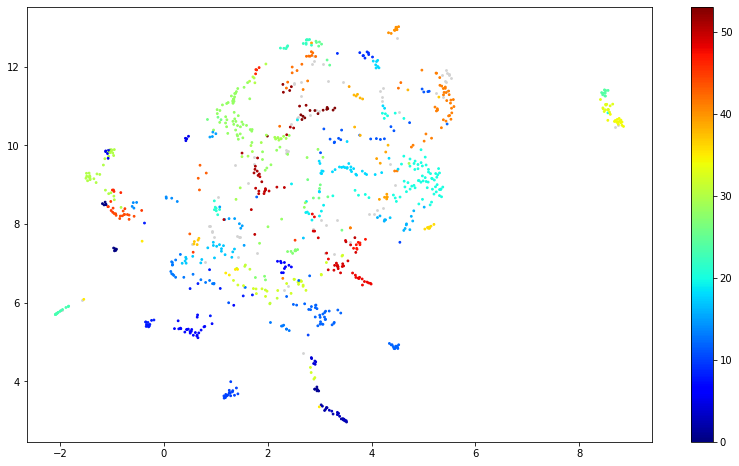

In [46]:
plot_clusters(embeddings_use, best_clusters_use)

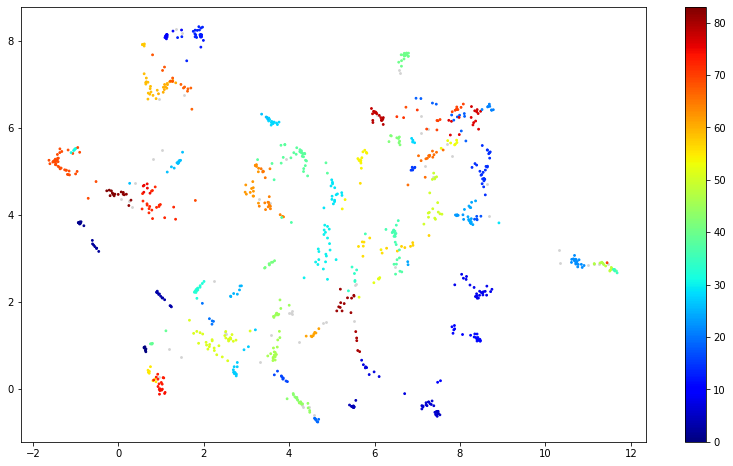

In [47]:
plot_clusters(embeddings_st1, best_clusters_st1)

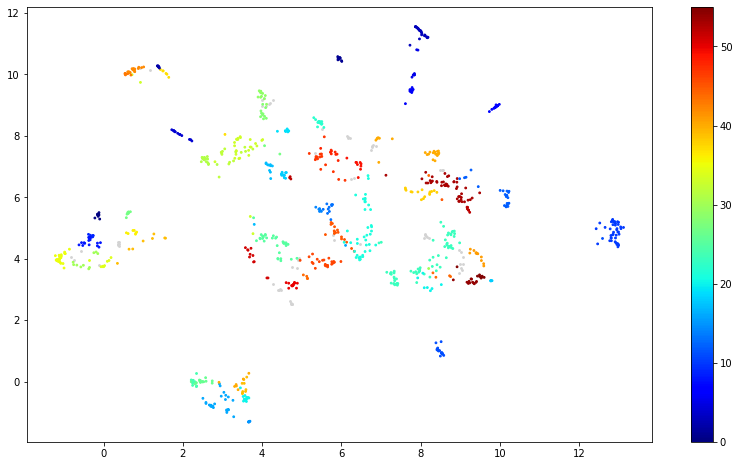

In [48]:
plot_clusters(embeddings_st2, best_clusters_st2)

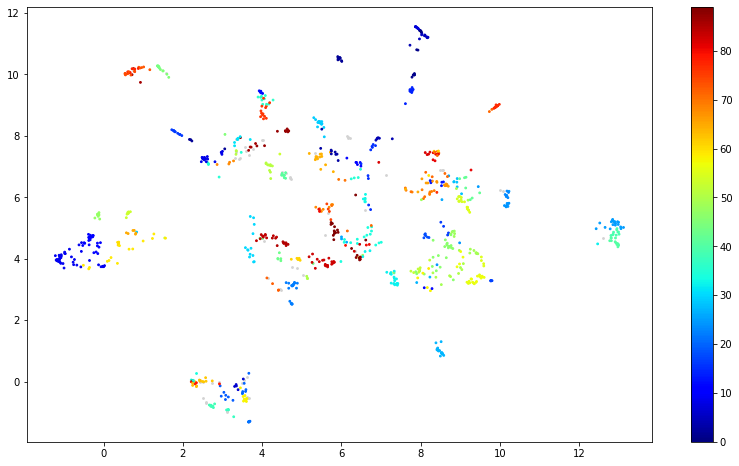

In [49]:
plot_clusters(embeddings_st3, best_clusters_st3)

### Compare clustering performance using ground truth labels

In [50]:
cluster_dict = {'label_use': best_clusters_use,
                'label_st1': best_clusters_st1, 
                'label_st2': best_clusters_st2,
                'label_st3': best_clusters_st3}

results_df = combine_results(data_sample[['text', 'category']], cluster_dict)
    
results_df.head()

,text,category,label_use,label_st1,label_st2,label_st3
0,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,41,27,18,41
1,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,28,38,46,43
2,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,28,38,46,83
3,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,53,78,23,32
4,Are there ways for other people to send me money?,receiving_money,14,18,44,50


In [73]:
model_dict = {'USE': ['label_use', best_params_use, trials_use],
              'all-mpnet-base-v2': ['label_st1', best_params_st1, trials_st1],
              'all-MiniLM-L6-v2': ['label_st2', best_params_st2, trials_st2],
              'all-distilroberta-v1': ['label_st3', best_params_st3, trials_st3]
               }

summarize_results(model_dict, results_df)

,Model,ARI,NMI,loss,label_count,n_neighbors,n_components,min_cluster_size,random_state
1,all-mpnet-base-v2,0.484,0.820,0.057,85,5,14,4,42
3,all-distilroberta-v1,0.404,0.786,0.069,91,3,13,4,42
2,all-MiniLM-L6-v2,0.396,0.774,0.067,57,4,14,6,42
0,USE,0.263,0.696,0.087,55,3,10,5,42


### Manually inspect category consistency

In [34]:
results_df[results_df['label_use']==2]

,text,category,label_use,label_st1,label_st2,label_st3
82,"Can I use my account now, even though my identity verification has not gone through yet?",why_verify_identity,2,23,4,-1
101,Can you tell me what I need for identity validation?,verify_my_identity,2,15,4,6
104,What documentation do you accept for the identity check?,verify_my_identity,2,15,4,6
214,What is the purpose of requiring my identification?,why_verify_identity,2,15,4,6
397,Can I use my account although the identity verification has not been accepted yet?,why_verify_identity,2,23,4,-1
530,What do I need in regards to identification?,verify_my_identity,2,15,4,6
618,Can i make transactions before identity verification?,why_verify_identity,2,23,4,6
621,Is there anyway to bypass identity verification?,why_verify_identity,2,23,4,-1
910,What do you require for identification verification?,verify_my_identity,2,15,4,6
930,what documents do i need to verify who i am,verify_my_identity,2,15,4,6


In [35]:
results_df[results_df['category']=='country_support']

,text,category,label_use,label_st1,label_st2,label_st3
11,Do you do business in the EU?,country_support,35,26,5,12
44,What are the countries you have offices in?,country_support,0,29,5,-1
122,Can I use this all over the world?,country_support,45,28,21,-1
279,What countries are you available in?,country_support,0,29,5,-1
295,What are the countries that you operate in?,country_support,0,29,5,-1
311,Can I get a card in the EU?,country_support,35,-1,5,12
503,Which countries do you operate in,country_support,0,29,5,-1
600,How do I know which countries you provide service in?,country_support,0,29,5,-1
724,"I'm not in the UK, but can I still get a card?",country_support,35,-1,5,-1
732,Can I get support?,country_support,-1,30,25,-1


Both USE and ST1 models have high precision for `country_support` category but also both miss many instances in that group.

In [36]:
results_df[results_df['category']=='card_about_to_expire']

,text,category,label_use,label_st1,label_st2,label_st3
27,"I am overseas in China, can I get a replacement card?",card_about_to_expire,12,-1,-1,25
370,"If I am in China, can I still order a new card and if so, how?",card_about_to_expire,12,-1,-1,25
441,My card is almost expired. How fast will I get a new one and what is the cost?,card_about_to_expire,6,49,27,16
477,My card is about to expire. Do I have to go to a branch to order a new card?,card_about_to_expire,6,49,27,16
521,"My card expires soon, will you send me one automatically?",card_about_to_expire,6,49,27,16
524,My card expires very soon. What is the cost and delivery time to get a new one?,card_about_to_expire,6,49,27,16
551,Where can I have a new bank card sent to China?,card_about_to_expire,12,-1,-1,25
584,How do I get a new expiration date?,card_about_to_expire,6,49,27,16
605,Are there any express fees if i want my new card faster?,card_about_to_expire,-1,49,17,16
646,My card is almost going to expire.,card_about_to_expire,6,49,-1,16


In [121]:
results_df[results_df['label_st1']==25]

,text,category,label_use,label_st1,label_st2,label_st3
12,"Can I add other people to my account, so they can top up?",topping_up_by_card,45,25,21,30
208,How can my friends top up my account?,topping_up_by_card,-1,25,21,30
549,Show me how can my friends top up my account.,topping_up_by_card,64,25,21,30
673,I want to top up my account. What payment methods are supported?,supported_cards_and_currencies,64,25,21,30
749,Help me to set up contactless payments.,contactless_not_working,68,25,-1,41
909,I want to use a payment card to top up my account. How can I do this?,supported_cards_and_currencies,64,25,21,30


### Save cluster results

In [124]:
results_df.to_csv('../data/processed/sample_clustered.csv')

## Applying to the full dataset of 10k intents

In [97]:
data_full = pd.read_csv('../data/raw/train.csv')
data_full.head()

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived after 2 weeks?,card_arrival
2,I have been waiting over a week. Is the card still coming?,card_arrival
3,Can I track my card while it is in the process of delivery?,card_arrival
4,"How do I know if I will get my card, or if it is lost?",card_arrival


In [98]:
all_intents_full = list(data_full['text'])
len(all_intents_full)

10003

In [99]:
embeddings_use = embed(model_use, 'use', all_intents_full)
embeddings_st1 = embed(model_st1, 'sentence transformer', all_intents_full)
embeddings_st2 = embed(model_st2, 'sentence transformer', all_intents_full)
embeddings_st3 = embed(model_st3, 'sentence transformer', all_intents_full)

In [158]:
best_params_use, trials_use = bayesian_search(embeddings_use, max_evals=100)

100%|██████████| 100/100 [17:06<00:00, 10.26s/trial, best loss: 0.13026092172348294]
best:
{'min_cluster_size': 33, 'min_samples': 23, 'n_components': 24, 'n_neighbors': 6}
label count: 51


In [109]:
best_params_use, trials_use = bayesian_search(embeddings_use, max_evals=100)

100%|██████████| 100/100 [14:59<00:00,  9.00s/trial, best loss: 0.11696491052684195]
best:
{'min_cluster_size': 27, 'n_components': 23, 'n_neighbors': 3}
label count: 84


In [110]:
best_params_st1, trials_st1 = bayesian_search(embeddings_st1, max_evals=100)

100%|██████████| 100/100 [16:12<00:00,  9.73s/trial, best loss: 0.09757072878136559]
best:
{'min_cluster_size': 34, 'n_components': 17, 'n_neighbors': 4}
label count: 67


In [111]:
best_params_st2, trials_st2 = bayesian_search(embeddings_st2, max_evals=100)

100%|██████████| 100/100 [19:41<00:00, 11.82s/trial, best loss: 0.09537138858342498]
best:
{'min_cluster_size': 32, 'n_components': 24, 'n_neighbors': 10}
label count: 70


In [112]:
best_params_st3, trials_st3 = bayesian_search(embeddings_st3, max_evals=100)

100%|██████████| 100/100 [17:56<00:00, 10.76s/trial, best loss: 0.13236029191242626]
best:
{'min_cluster_size': 29, 'n_components': 23, 'n_neighbors': 5}
label count: 72


In [113]:
best_clusters_use = best_clusters(embeddings_use, best_params_use)

In [114]:
best_clusters_st1 = best_clusters(embeddings_st1, best_params_st1)

In [115]:
best_clusters_st2 = best_clusters(embeddings_st2, best_params_st2)

In [116]:
best_clusters_st3 = best_clusters(embeddings_st3, best_params_st3)

In [139]:
cluster_dict = {'label_use': best_clusters_use, 
                    'label_st1': best_clusters_st1, 
                    'label_st2': best_clusters_st2,
                    'label_st3': best_clusters_st3}

results_df = combine_results(data_full, cluster_dict)
    
results_df.head()

,text,category,label_use,label_st1,label_st2,label_st3
0,I am still waiting on my card?,card_arrival,41,52,36,27
1,What can I do if my card still hasn't arrived after 2 weeks?,card_arrival,41,52,36,27
2,I have been waiting over a week. Is the card still coming?,card_arrival,41,52,36,27
3,Can I track my card while it is in the process of delivery?,card_arrival,-1,52,36,26
4,"How do I know if I will get my card, or if it is lost?",card_arrival,65,36,36,57


In [142]:
model_dict = {'USE': 'label_use', 
              'Sent-Transformer_1': 'label_st1', 
              'Sent-Transformer_2': 'label_st2', 
              'Sent-Transformer_3': 'label_st3'}

comparison_table(model_dict, results_df)

,Model,ARI,NMI
0,USE,0.253,0.666
1,Sent-Transformer_1,0.300,0.705
2,Sent-Transformer_2,0.320,0.736
3,Sent-Transformer_3,0.262,0.705
